<a href="https://colab.research.google.com/github/bbutka/CEC220/blob/main/State_Machine_Design_JK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter the number of state variables: 3
Enter the number of input variables: 1
Enter the number of output variables: 1


Button(description='Generate State Diagram', style=ButtonStyle())

S2 | S1 | S0 | D0 | S2N | S1N | S0N | F0 | TS2 | TS1 | TS0 | J2 | K2 | J1 | K1 | J0 | K0
----------------------------------------------------------------------------------------
   0 |    0 |    0 |    0 |    0 |    0 |    0 |    0 | 0→0 | 0→0 | 0→0 | 0 | X | 0 | X | 0 | X
   0 |    0 |    0 |    1 |    1 |    0 |    0 |    1 | 0→1 | 0→0 | 0→0 | 1 | X | 0 | X | 0 | X
   0 |    0 |    1 |    0 |    0 |    0 |    0 |    0 | 0→0 | 0→0 | 1→0 | 0 | X | 0 | X | X | 1
   0 |    0 |    1 |    1 |    0 |    1 |    0 |    0 | 0→0 | 0→1 | 1→0 | 0 | X | 1 | X | X | 1
   0 |    1 |    0 |    0 |    0 |    0 |    1 |    0 | 0→0 | 1→0 | 0→1 | 0 | X | X | 1 | 1 | X
   0 |    1 |    0 |    1 |    0 |    0 |    0 |    0 | 0→0 | 1→0 | 0→0 | 0 | X | X | 1 | 0 | X
   0 |    1 |    1 |    0 |    0 |    0 |    0 |    0 | 0→0 | 1→0 | 1→0 | 0 | X | X | 1 | X | 1
   0 |    1 |    1 |    1 |    0 |    0 |    0 |    0 | 0→0 | 1→0 | 1→0 | 0 | X | X | 1 | X | 1
   1 |    0 |    0 |    0 |    0 |    0 |    0 |    0 

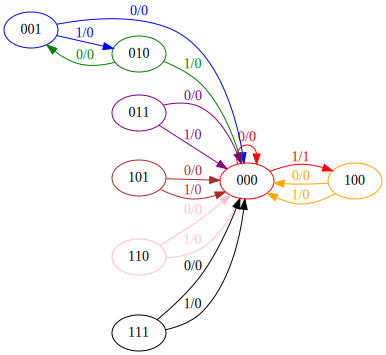

J0 = D0 & ~S0 & ~S1
K0 = True
J1 = D0 & S0 & ~S2
K1 = True
J2 = S1 & ~D0 & ~S2
K2 = True
F0 = D0 & ~S0 & ~S1 & ~S2


In [24]:
import graphviz
import sympy as sp
from sympy.logic.boolalg import SOPform
import ipywidgets as widgets
from ipywidgets import Layout, HBox, VBox, HTML, RadioButtons
from IPython.display import display

def generate_state_transition_table(state_vars, input_vars, output_vars):
    """Generate input widgets for the state transition table."""
    num_states = 2 ** state_vars
    num_inputs = 2 ** input_vars if input_vars > 0 else 1
    rows = num_states * num_inputs
    table_input = []
    headers = [f'S{i}' for i in range(state_vars-1, -1, -1)] + [f'D{i}' for i in range(input_vars-1, -1, -1)] + [f'Next S{i}' for i in range(state_vars-1, -1, -1)] + [f'F{i}' for i in range(output_vars-1, -1, -1)]

    style = HTML(
        "<style>.widget-radio-box {flex-direction: row !important;}.widget-radio-box"
        " label{margin:5px !important;width: 50px !important;}</style>",
        layout=Layout(display="none"),
    )

    for i in range(rows):
        row_widgets = []
        state = i // num_inputs
        inp = i % num_inputs
        state_bits = f"{state:0{state_vars}b}"
        input_bits = f"{inp:0{input_vars}b}" if input_vars > 0 else ""

        for bit in state_bits + input_bits:
            row_widgets.append(widgets.Label(value=bit, layout=Layout(width='40px', text_align='center')))

        for j in range(state_vars):
            radio_buttons = RadioButtons(options=['1', '0', 'X'], value='0', layout=Layout(display='flex', flex_direction='row'))
            row_widgets.append(HBox([radio_buttons, style]))

        for j in range(output_vars):
            radio_buttons = RadioButtons(options=['1', '0', 'X'], value='0', layout=Layout(display='flex', flex_direction='row'))
            row_widgets.append(HBox([radio_buttons, style]))

        table_input.append(row_widgets)
    return table_input, headers

def display_state_transition_table(table_input, headers):
    """Display the state transition table input widgets."""
    header_widgets = []
    for header in headers:
        if header.endswith('D0'):
            header_widgets.append(widgets.Label(value=header, layout=Layout(width='100px', text_align='center')))
        elif header.startswith('Next S') or header.startswith('F') or header.endswith('D0'):
            header_widgets.append(widgets.Label(value=header, layout=Layout(width='300px', text_align='center')))
        else:
            header_widgets.append(widgets.Label(value=header, layout=Layout(width='40px', text_align='center')))
    display(HBox(header_widgets))

    for row in table_input:
        display(HBox(row, layout=Layout(margin='0')))

def parse_state_transition_table_input(table_input, state_vars, input_vars, output_vars):
    """Parse the user input from the state transition table."""
    transition_table = []
    dont_cares = []
    num_states = 2 ** state_vars
    num_inputs = 2 ** input_vars if input_vars > 0 else 1
    for row in table_input:
        state_input = [int(row[i].value) for i in range(state_vars)]
        inputs = [int(row[state_vars + i].value) for i in range(input_vars)] if input_vars > 0 else []
        next_state = [row[state_vars + input_vars + i].children[0].value.strip() for i in range(state_vars)]
        outputs = [row[state_vars + input_vars + state_vars + i].children[0].value.strip() for i in range(output_vars)]
        if not all(ns == 'X' for ns in next_state):
            transition_table.append(state_input + inputs + next_state + outputs)
        else:
            dont_cares.append(state_input + inputs + next_state + outputs)
    return transition_table, dont_cares

def print_transition_table(transition_table, state_vars, input_vars, output_vars):
    """Print the transition table and return the J and K variables."""
    headers = (
        [f'S{i}' for i in range(state_vars - 1, -1, -1)]
        + [f'D{i}' for i in range(input_vars - 1, -1, -1)]
        + [f'S{i}N' for i in range(state_vars - 1, -1, -1)]
        + [f'F{i}' for i in range(output_vars - 1, -1, -1)]
    )

    # Add TS columns together
    ts_headers = []
    jk_headers = []
    for i in range(state_vars - 1, -1, -1):
        ts_headers.append(f'TS{i}')
        jk_headers.append(f'J{i}')
        jk_headers.append(f'K{i}')

    headers.extend(ts_headers)
    headers.extend(jk_headers)

    header_str = " | ".join(headers)
    print(header_str)
    print("-" * len(header_str))

    jk_vars = []

    for row in transition_table:
        row_str = " | ".join(f"{x:>4}" for x in row)
        ts_values = []
        jk_values = []

        for i in range(state_vars):
            s = row[i]
            sn = row[state_vars + input_vars + i]
            ts = f"{s}→{sn}"
            ts_values.append(ts)

            if ts == "0→0":
                j, k = "0", "X"
            elif ts == "0→1":
                j, k = "1", "X"
            elif ts == "1→0":
                j, k = "X", "1"
            elif ts == "1→1":
                j, k = "X", "0"
            else:
                j, k = "-", "-"  # For invalid states

            jk_values.extend([j, k])

        ts_jk_str = " | ".join(ts_values + jk_values)
        print(f"{row_str} | {ts_jk_str}")

        jk_vars.append(jk_values)

    return jk_vars

def create_state_machine(transition_table, state_vars, input_vars, output_vars):
    """Create and display the state machine diagram based on the transition table."""
    fsm = graphviz.Digraph(format='png')
    fsm.attr(rankdir='LR', size='12,8')  # Increased the size to accommodate larger state machines

    state_colors = ["red", "blue", "green", "purple", "orange", "brown", "pink", "black"]
    state_color_map = {}

    # Filter out states with all next states as 'X'
    valid_states = {tuple(row[:state_vars]) for row in transition_table}
    valid_states = sorted(valid_states, key=lambda s: int(''.join(map(str, s)), 2))

    # Assign colors to valid states
    for i, state in enumerate(valid_states):
        state_color_map[state] = state_colors[i % len(state_colors)]

    # Add states to the diagram
    for state in valid_states:
        state_str = ''.join(map(str, state))
        fsm.node(state_str, state_str, color=state_color_map[state])

    # Add transitions to the diagram
    for row in transition_table:
        current_state = tuple(row[:state_vars])
        input_bits = ''.join(map(str, row[state_vars:state_vars + input_vars])) if input_vars > 0 else ''
        next_state = tuple(row[state_vars + input_vars:state_vars + input_vars + state_vars])
        output_bits = ''.join(map(str, row[state_vars + input_vars + state_vars:state_vars + input_vars + state_vars + output_vars]))
        next_state_str = ''.join(map(str, next_state))
        current_state_str = ''.join(map(str, current_state))
        color = state_color_map[current_state]
        fsm.edge(current_state_str, next_state_str, label=f"{input_bits}/{output_bits}", color=color, fontcolor=color)

    display(fsm)

def simplify_expression_from_truth_table(truth_table, num_vars, state_vars_list, input_vars_list):
    """Simplify the logic expression based on the truth table using Quine-McCluskey algorithm."""
    variables = state_vars_list + input_vars_list
    minterms = []
    dont_cares = []
    for row in truth_table:
        if row[-1] == '1':
            minterms.append(row[:num_vars])
        elif row[-1] == 'X':
            dont_cares.append(row[:num_vars])

    # Convert minterms and don't-cares to integers
    minterms_int = [int(''.join(map(str, m)), 2) for m in minterms]
    dont_cares_int = [int(''.join(map(str, dc)), 2) for dc in dont_cares]

    # Use SymPy's SOPform with minterms and don't-cares
    simplified_expr = sp.SOPform(variables, minterms=minterms_int, dontcares=dont_cares_int)
    return simplified_expr

def generate_logic_expressions(transition_table, jk_vars, state_vars, input_vars, output_vars):
    """Generate and display the logic expressions for Jx, Kx, and Fx using Quine-McCluskey algorithm and print the values for all input states."""
    state_vars_list = [sp.symbols(f'S{i}') for i in range(state_vars-1, -1, -1)]
    input_vars_list = [sp.symbols(f'D{i}') for i in range(input_vars-1, -1, -1)]
    all_vars_list = state_vars_list + input_vars_list

    expressions = {}
    num_jk_columns = state_vars

    for i in range(num_jk_columns):
        j_truth_table = []
        k_truth_table = []

        for row, jk in zip(transition_table, jk_vars):
            state_input = row[:state_vars + input_vars]
            j_value = jk[i * 2]
            k_value = jk[i * 2 + 1]

            j_truth_table.append(state_input + [j_value])
            k_truth_table.append(state_input + [k_value])

        # Simplify J and K expressions using the provided method
        j_expr = simplify_expression_from_truth_table(j_truth_table, state_vars + input_vars, state_vars_list, input_vars_list)
        k_expr = simplify_expression_from_truth_table(k_truth_table, state_vars + input_vars, state_vars_list, input_vars_list)

        expressions[sp.symbols(f'J{i}')] = j_expr
        expressions[sp.symbols(f'K{i}')] = k_expr

        print(f"J{i} = {j_expr}")
        print(f"K{i} = {k_expr}")

    for i in range(output_vars):
        f_truth_table = []

        for row in transition_table:
            state_input = row[:state_vars + input_vars]
            f_value = row[state_vars + input_vars + state_vars + i]
            f_truth_table.append(state_input + [f_value])

        # Simplify F expressions using the provided method
        f_expr = simplify_expression_from_truth_table(f_truth_table, state_vars + input_vars, state_vars_list, input_vars_list)

        expressions[sp.symbols(f'F{i}')] = f_expr

        print(f"F{i} = {f_expr}")

    # Print the values of J, K, and F for all input states along with the original column values
    for row, jk in zip(transition_table, jk_vars):
        state_input = row[:state_vars + input_vars]
        j_k_f_values = []
        for i in range(num_jk_columns):
            j_expr = expressions[sp.symbols(f'J{i}')]
            k_expr = expressions[sp.symbols(f'K{i}')]
            original_j_value = jk[i * 2]
            original_k_value = jk[i * 2 + 1]
            if original_j_value != 'X':
                j_value = bool(j_expr.subs(dict(zip(all_vars_list, state_input))))
            else:
                j_value = 'X'
            if original_k_value != 'X':
                k_value = bool(k_expr.subs(dict(zip(all_vars_list, state_input))))
            else:
                k_value = 'X'
            j_k_f_values.append((original_j_value, j_value, original_k_value, k_value))

        f_values = []
        for i in range(output_vars):
            f_expr = expressions[sp.symbols(f'F{i}')]
            original_f_value = row[state_vars + input_vars + state_vars + i]
            if original_f_value != 'X':
                f_value = bool(f_expr.subs(dict(zip(all_vars_list, state_input))))
            else:
                f_value = 'X'
            f_values.append((original_f_value, f_value))



# Function to ask for user input and create the state transition table
def create_state_transition_table():
    state_vars = int(input("Enter the number of state variables: "))
    input_vars = int(input("Enter the number of input variables: "))
    output_vars = int(input("Enter the number of output variables: "))

    table_input, headers = generate_state_transition_table(state_vars, input_vars, output_vars)
    display_state_transition_table(table_input, headers)

    def on_button_click(b):
        transition_table, dont_cares = parse_state_transition_table_input(table_input, state_vars, input_vars, output_vars)
        jk_vars = print_transition_table(transition_table, state_vars, input_vars, output_vars)
        create_state_machine(transition_table, state_vars, input_vars, output_vars)
        generate_logic_expressions(transition_table, jk_vars, state_vars, input_vars, output_vars)

    button = widgets.Button(description="Generate State Diagram")
    button.on_click(on_button_click)
    display(button)

# Run the function to create the state transition table
create_state_transition_table()
